# Raman Spectra Quality Control

## Setup

Import required packages

In [1]:
import os

from raman_lib.spectra_scoring import score_sort_spectra
from raman_lib.misc import load_data
from raman_lib.visualization import plot_spectra_peaks
from raman_lib.preprocessing import RangeLimiter

Settings

In [2]:
# Name of the Dataset (for the output file)
name = "Biofilme"

# Path where the data is stored
path = r"./data"

# Spectral range to analyze
# Use 'None' to use the whole range'
wn_min = 400
wn_max = 1600

# QC settings - Choose either A or B and set the other to 'None'
# A)
n = None # How many spectra (per class) to keep (exactly this number - or less 
         # if a class does not contain enough spectra)
         
# B)
score_min = 5000 # Minimum quality score that a spectrum must have to be kept.
n_min = 10 # Number of spectra that will be kept per class regardless of the score

# Window size for the Savitzky-Golay-Filter. Higher means stronger smoothing and less peaks found
sg_window = 15

# Threshold for the second derivative. Higher means less peaks found.
threshold = 50

## Load Data

In [3]:
data = load_data(path)

print("Number of spectra per class:")
print(data.label.value_counts())

Number of spectra per class:
1B      48
W       32
W+2B    16
2B      16
W+1B    15
PW      15
Name: label, dtype: int64


## Scoring and Spectra Selection

In [4]:
data_new, score_dict = score_sort_spectra(data, 
                                          n=n,
                                          min_score=score_min, 
                                          min_n=n_min,
                                          limits=(wn_min, wn_max), 
                                          sg_window=sg_window, 
                                          threshold=threshold, 
                                          detailed=True)

print()
print("====================================")
print()
print("Number of spectra per class (after QC):")
print(data_new.label.value_counts())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15511.105484958822, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7103.4010158613555, 0, 0, 0, 0, 0, 7103.4010158613555, 0, 0, 0, 0, 0, 6719.808539166923, 0, 0, 0, 6093.8150872091865, 0, 6719.808539166923, 0, 0, 6093.8150872091865, 0, 0, 0, 0, 0, 0]
Analyzed 142 spectra in 1.67 

In [5]:
rl = RangeLimiter(lim=(wn_min, wn_max), 
                  reference=data.drop(columns=["label", "file"]).columns)

data_rl = rl.fit_transform(data.drop(columns=["label", "file"]).values)
wns_rl = data.drop(columns=["label", "file"]).columns[rl.lim_[0]:rl.lim_[1]]

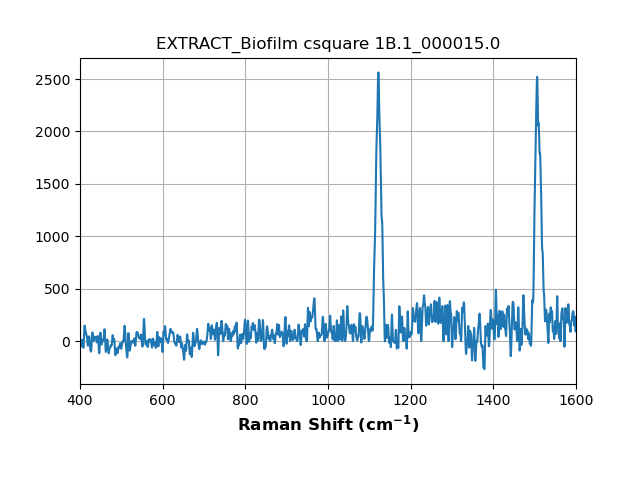

In [6]:
%matplotlib widget
plot_spectra_peaks(wns_rl, 
                   data_rl, 
                   score_dict["peak_pos"],
                   labels=data.file)

## Export selected spectra

In [12]:
filename = name.lower().replace(" ", "_") + ".csv"

if not os.path.exists("./results_qc/"):
    os.mkdir("./results_qc/")

data_new.to_csv(os.path.join("./results_qc/", filename), index=False)